In [ ]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libfontenc1:amd64.
(Reading database ... 123629 files and directories currently installed.)
Preparing to unpack .../0-libfontenc1_1%3a1.1.4-1build3_amd64.deb ...
Unpacking libfontenc1:amd64 (1:1.1.4-1build3) ...
Selecting previously unselected package libxfont2:amd64.
Preparing to unpack .../1-libxfont2_1%3a2.0.5-1build1_amd64.deb ...
Unpacking libxfont2:amd64 (1:2.0.5-1build1) ...
Selecting previously unselected package libxkbfile1:amd64.
Preparing to unpack .../2-libxkbfile1_1%3a1.1.0-1build3_amd64.deb ...
Unpacking libxkbfile1:amd64 (1:1.1.0-1build3) ...
Selecting previously unselected package x11-xkb-utils.
Preparing to unpack .../3-x11-xkb-utils_7.7+5build4_amd64.deb ...
Unpacking x11-xkb-utils (7.7+5build4) ...
Selecting previously unselected package xfon

# Approximate q-learning (10 pts)

In this notebook you will teach a __PyTorch__ neural network to do Q-learning.

In [ ]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for

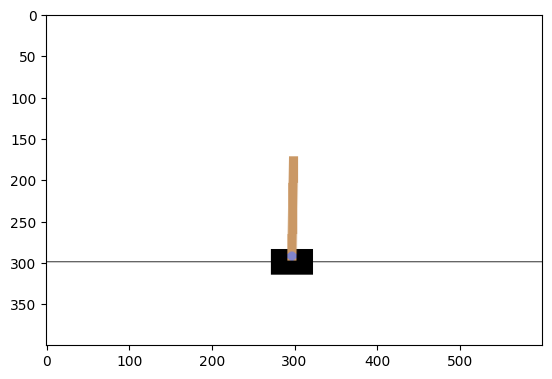

In [ ]:
env = gym.make("CartPole-v0").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))
env.close()

# Approximate Q-learning: building the network

To train a neural network policy one must have a neural network policy. Let's build it.


Since we're working with a pre-extracted features (cart positions, angles and velocities), we don't need a complicated network yet. In fact, let's build something like this for starters:

![img](https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/yet_another_week/_resource/qlearning_scheme.png)

For your first run, please only use linear layers (`nn.Linear`) and activations. Stuff like batch normalization or dropout may ruin everything if used haphazardly.

Also please avoid using nonlinearities like sigmoid & tanh: since agent's observations are not normalized, sigmoids might be saturated at initialization. Instead, use non-saturating nonlinearities like ReLU.

Ideally you should start small with maybe 1-2 hidden layers with < 200 neurons and then increase network size if agent doesn't beat the target score.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
network = nn.Sequential()

network.add_module('layer1', nn.Linear(state_dim[0], 128))
network.add_module('relu1', nn.ReLU())
network.add_module('layer2', nn.Linear(128, 64))
network.add_module('relu2', nn.ReLU())
network.add_module('output', nn.Linear(64, n_actions))


# hint: use state_dim[0] as input size

In [ ]:
def get_action(state, epsilon=0):
    state = torch.tensor(state[None], dtype=torch.float32)
    q_values = network(state).detach().numpy()
    if np.random.rand() < epsilon:
        return int(np.random.choice(n_actions))
    return int(np.argmax(q_values))

In [ ]:
s = env.reset()
assert tuple(network(torch.tensor([s]*3, dtype=torch.float32)).size()) == (
    3, n_actions), "please make sure your model maps state s -> [Q(s,a0), ..., Q(s, a_last)]"
assert isinstance(list(network.modules(
))[-1], nn.Linear), "please make sure you predict q-values without nonlinearity (ignore if you know what you're doing)"
assert isinstance(get_action(
    s), int), "get_action(s) must return int, not %s. try int(action)" % (type(get_action(s)))

# test epsilon-greedy exploration
for eps in [0., 0.1, 0.5, 1.0]:
    state_frequencies = np.bincount(
        [get_action(s, epsilon=eps) for i in range(10000)], minlength=n_actions)
    best_action = state_frequencies.argmax()
    assert abs(state_frequencies[best_action] -
               10000 * (1 - eps + eps / n_actions)) < 200
    for other_action in range(n_actions):
        if other_action != best_action:
            assert abs(state_frequencies[other_action] -
                       10000 * (eps / n_actions)) < 200
    print('e=%.1f tests passed' % eps)

e=0.0 tests passed
e=0.1 tests passed
e=0.5 tests passed
e=1.0 tests passed


### Q-learning via gradient descent

We shall now train our agent's Q-function by minimizing the TD loss:
$$ L = { 1 \over N} \sum_i (Q_{\theta}(s,a) - [r(s,a) + \gamma \cdot max_{a'} Q_{-}(s', a')]) ^2 $$


Where
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

The tricky part is with  $Q_{-}(s',a')$. From an engineering standpoint, it's the same as $Q_{\theta}$ - the output of your neural network policy. However, when doing gradient descent, __we won't propagate gradients through it__ to make training more stable.

To do so, we shall use `x.detach()` function which basically says "consider this thing constant when doingbackprop".

In [ ]:
def compute_td_loss(states, actions, rewards, next_states, is_done, gamma=0.99, check_shapes=False):
    """ Compute TD loss using the given formula. """
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.long)
    rewards = torch.tensor(rewards, dtype=torch.float32)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    is_done = torch.tensor(is_done, dtype=torch.uint8)

    predicted_qvalues = network(states)
    predicted_qvalues_for_actions = predicted_qvalues[
        range(states.shape[0]), actions
    ]

    predicted_next_qvalues = network(next_states)
    next_state_values = torch.max(predicted_next_qvalues, dim=1)[0]
    assert next_state_values.dtype == torch.float32

    target_qvalues_for_actions = rewards + gamma * next_state_values

    target_qvalues_for_actions = torch.where(
        is_done, rewards, target_qvalues_for_actions
    )

    loss = torch.mean((predicted_qvalues_for_actions -
                       target_qvalues_for_actions.detach()) ** 2)

    if check_shapes:
        assert predicted_next_qvalues.data.dim() == 2, "Predicted Q-values for next states must have shape [batch, actions]"
        assert next_state_values.data.dim() == 1, "V(s') must be a vector"
        assert target_qvalues_for_actions.data.dim() == 1, "Target Q-values must be a vector"

    return loss

In [ ]:
# sanity checks
s = env.reset()
a = env.action_space.sample()
next_s, r, done, _ = env.step(a)

loss = compute_td_loss([s], [a], [r], [next_s], [done], check_shapes=True)
loss.backward()

assert len(loss.size()) == 0, "you must return scalar loss - mean over batch"
assert np.any(next(network.parameters()).grad.detach().numpy() != 0), "loss must be differentiable"


### Playing the game

In [ ]:
opt = torch.optim.Adam(network.parameters(), lr=1e-4)

In [ ]:
def generate_session(env, t_max=1000, epsilon=0, train=False):
    """Play environment with approximate Q-learning agent and train it at the same time."""
    total_reward = 0
    s = env.reset()

    for t in range(t_max):
        a = get_action(s, epsilon=epsilon)
        next_s, r, done, _ = env.step(a)

        if train:
            opt.zero_grad()
            loss = compute_td_loss([s], [a], [r], [next_s], [done])
            loss.backward()
            opt.step()

        total_reward += r
        s = next_s
        if done:
            break

    return total_reward

In [ ]:
epsilon = 0.5

In [ ]:
for i in range(1000):
    session_rewards = [generate_session(env, epsilon=epsilon, train=True) for _ in range(100)]
    print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards), epsilon))

    epsilon *= 0.99
    assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"

    if np.mean(session_rewards) > 300:
        print("You Win!")
        break

epoch #0	mean reward = 14.340	epsilon = 0.500
epoch #1	mean reward = 13.420	epsilon = 0.495
epoch #2	mean reward = 14.420	epsilon = 0.490
epoch #3	mean reward = 13.420	epsilon = 0.485
epoch #4	mean reward = 15.640	epsilon = 0.480
epoch #5	mean reward = 16.140	epsilon = 0.475
epoch #6	mean reward = 20.230	epsilon = 0.471
epoch #7	mean reward = 22.830	epsilon = 0.466
epoch #8	mean reward = 32.060	epsilon = 0.461
epoch #9	mean reward = 32.000	epsilon = 0.457
epoch #10	mean reward = 41.200	epsilon = 0.452
epoch #11	mean reward = 42.410	epsilon = 0.448
epoch #12	mean reward = 45.840	epsilon = 0.443
epoch #13	mean reward = 55.230	epsilon = 0.439
epoch #14	mean reward = 54.700	epsilon = 0.434
epoch #15	mean reward = 60.140	epsilon = 0.430
epoch #16	mean reward = 88.810	epsilon = 0.426
epoch #17	mean reward = 99.560	epsilon = 0.421
epoch #18	mean reward = 136.610	epsilon = 0.417
epoch #19	mean reward = 141.350	epsilon = 0.413
epoch #20	mean reward = 140.130	epsilon = 0.409
epoch #21	mean rewar

### How to interpret results


Welcome to the f.. world of deep f...n reinforcement learning. Don't expect agent's reward to smoothly go up. Hope for it to go increase eventually. If it deems you worthy.

Seriously though,
* __ mean reward__ is the average reward per game. For a correct implementation it may stay low for some 10 epochs, then start growing while oscilating insanely and converges by ~50-100 steps depending on the network architecture.
* If it never reaches target score by the end of for loop, try increasing the number of hidden neurons or look at the epsilon.
* __ epsilon__ - agent's willingness to explore. If you see that agent's already at < 0.01 epsilon before it's is at least 200, just reset it back to 0.1 - 0.5.

In [ ]:
#мяу#